In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from sklearn.model_selection import train_test_split

import torch
import re
import os
import shutil
import glob
import zipfile
import cv2

In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('device :', device)
print('Current :', torch.cuda.current_device())
print('Count :', torch.cuda.device_count())

device : cuda
Current : 0
Count : 1


In [15]:
data = pd.read_csv('골밀도 데이터/train_data.csv')
data.head()

,Group,등록번호,생년월일,성별,진료의,검사 시 나이,신장,체중,BMI,처방일자,시행일자,BA 1,BA 2,Unnamed: 14,No,boneage
0,1673,8225553,2004-09-30,F,1,11.654795,144.7,33.0,15.8,2016-05-24,2016-05-24,12.00,12.25,NaN,98.jpg,12.125
1,228,5889504,2006-09-15,M,1,8.389041,123.3,25.1,16.6,2014-08-04,2015-02-02,7.00,7.25,NaN,1162.jpg,7.125
2,311,5931393,2000-02-02,M,1,11.161644,138.0,37.0,19.5,2011-03-30,2011-03-30,9.75,11.25,NaN,636.jpg,10.500
3,2053,8807714,2014-08-20,M,1,4.967123,102.5,15.2,14.5,2019-08-07,2019-08-07,4.25,4.00,NaN,990.jpg,4.125
4,32,3726179,2000-05-24,M,1,10.860274,135.5,32.6,17.8,2011-04-01,2011-04-01,9.50,9.75,NaN,618.jpg,9.625


## 학습데이터 생성

In [16]:
def optimize_img(r1,r2,r3):
    tmp_binary_img = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) #CLAHE 생성
    for _,img in enumerate([r1,r2,r3]):
        if img is not None:
            # resized_img = cv2.resize(img,(1000,400)) # (400, 500)
            blured_img = cv2.GaussianBlur(img,(5,5),0)            
            clahed_img = clahe.apply(blured_img)          #CLAHE 적용
            _,binary_img = cv2.threshold(clahed_img,clahed_img.mean()*1.25,255,cv2.THRESH_BINARY)
            
            # 최종 이미지 크기
            target_size = 600
            old_size = binary_img.shape

            # 새로운 이미지 생성 (검은색 배경)
            new_image = np.zeros((target_size, target_size), dtype=np.uint8)

            # 이미지 중앙에 배치하기 위한 좌표 계산
            start_x = (target_size - old_size[1]) // 2
            start_y = (target_size - old_size[0]) // 2

            # 원본 이미지를 중앙에 배치
            new_image[start_y:start_y+old_size[0], start_x:start_x+old_size[1]] = binary_img
            
            tmp_binary_img.append(new_image)
                
    return np.array(tmp_binary_img)

In [17]:
def crop_img(img, roi_1, roi_2, roi_3):
    
    cropped_roi_1_img = img[roi_1[0][1]:roi_1[1][1],roi_1[0][0]:roi_1[1][0]]
    cropped_roi_2_img = img[roi_2[0][1]:roi_2[1][1],roi_2[0][0]:roi_2[1][0]]
    cropped_roi_3_img = img[roi_3[0][1]:roi_3[1][1],roi_3[0][0]:roi_3[1][0]]
    
    optimzed_imgs = optimize_img(cropped_roi_1_img,cropped_roi_2_img,cropped_roi_3_img)
    return optimzed_imgs

In [64]:
X_data = []
y_data = []
for k in range(len(data)):
    img0 = cv2.imread('골밀도 데이터/rotate_image/' + data.No[k], cv2.IMREAD_GRAYSCALE)

    # 이미지 thresholding
    r_img = np.copy(img0)
    height, width = img0.shape
    img = img0[0:(int)(height*0.9),0:(int)(width*0.95)]
    ret, img = cv2.threshold(img, img0.mean(), 255, cv2.THRESH_BINARY)

    # 이미지 contouring
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key = cv2.contourArea)
    mask = np.zeros(img.shape, dtype= np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255, 255, 255), -1)

    # 볼록한 점 구하기
    hull = cv2.convexHull(max_cnt, returnPoints= False)
    hull1 = cv2.convexHull(max_cnt)

    # 오목한 지점 구하기
    defects = cv2.convexityDefects(max_cnt, hull) # 인덱스로 반환

    # 거리를 저장할 수 있는 공간 생성
    di = []

    for index in range(defects.shape[0]):
        # 시작점, 끝점, far 점, 거리 할당
        sp, ep, fp, distance = defects[index, 0]
        
        # 거리 저장
        di.append(distance)

    far_xrange = []
    far_yrange = []
    start_xrange = []
    start_yrange = []

    # 가장 오목하게 들어가 있는 부분을 찾기 위해 sorting(내림차순)
    di = np.array(di)
    s_di = np.sort(di)[::-1]

    # 내림차순된 거리들을 6개만 뽑아내기 위해 slice
    for i in list(s_di[:6]):
        index = np.where(di == i)[0][0]
        
        sp, ep, fp, _ = defects[index, 0]
        
        far_xrange.append(max_cnt[fp][0][0])
        far_yrange.append(max_cnt[fp][0][1])
        
        start_xrange.append(max_cnt[sp][0][0])
        start_yrange.append(max_cnt[sp][0][1])
        

    #손목뼈 ROI
    carpus_start_point = ((int)(min(far_xrange[4:6])*0.90),(int)(max(far_yrange[4:6])*0.90))
    carpus_end_point = (int(max(far_xrange[4:6])*1.05),(int)(max(far_yrange[4:6])*1.15))
    
    #손목뼈 위쪽에 있는 관절 4개를 추출
    four_start_point = ((int)(min(far_xrange[0:4])*0.70),int(min(far_yrange[0:4])*0.95))
    four_end_point = (int(max(far_xrange[0:4])*1.05),(int)(max(far_yrange[0:4])*1.05))

    #중지 ROI 추출
    ## 중지 끝 좌표 구하기
    for y,x_r in enumerate(mask) :
        if 255 in x_r:
            #y에 따른 x rows 중 255인 x값 추출
            x_255_indexs = np.where(x_r == 255)[0]

            #255인 x값들 중 median 추출
            x_255_mid_index = x_255_indexs[(int)(len(x_255_indexs)/2)]
            first_255_x_point = x_255_mid_index

            first_255_y_point = y
            break
        
    sub = abs(first_255_x_point - far_xrange[0])
        
    middle_finger_start_point = (int((first_255_x_point - sub)), int(first_255_y_point*0.85))
    middle_finger_end_point = (int((first_255_x_point + sub)), int(far_yrange[0]*1.05))

    optimized_imgs = crop_img(img0,(carpus_start_point,carpus_end_point),
                            (four_start_point, four_end_point),(middle_finger_start_point,middle_finger_end_point))
    
    optimized_imgs = cv2.resize(optimized_imgs.reshape(600, 600, -1), (256, 256))
    
    X_data.append(optimized_imgs.reshape(256, 256, -1))
    y_data.append(data.boneage[k])

X_data = np.array(X_data)
y_data = np.array(y_data)

In [68]:
X_data.shape

(989, 256, 256, 3)

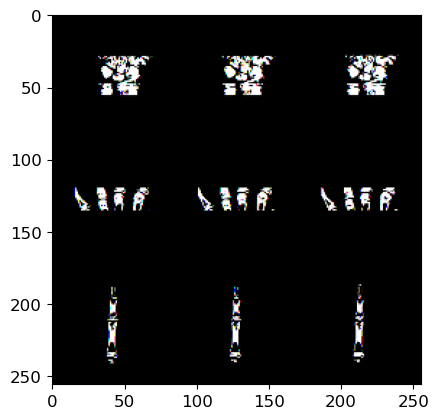

In [66]:
plt.imshow(X_data[0], 'gray')

### CNN 모델 생성 - Attention-Xception

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import torch

In [24]:
#separable 합성곱 함수
def separable_conv(x, inchannel,outchannel):
  x = keras.layers.Conv2D(inchannel, (3,3), strides=1, padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(outchannel, (1,1), strides=1, padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  return x

In [25]:
#resiual_units 함수 
def resiual_units(input_x):
  x = keras.layers.ReLU()(input_x)
  x = separable_conv(x,x.shape[-1],128)
  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.ReLU()(x)
  x = separable_conv(x,x.shape[-1],256)
  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.ReLU()(x)
  x = separable_conv(x,x.shape[-1],512)
  x = keras.layers.BatchNormalization()(x)
  
  input_x = keras.layers.Add()([x,input_x])

  return input_x

In [26]:
#model middle_flow 함수
def middle_flow(input_x):
  #encoder
  x = keras.layers.MaxPool2D((2,2),padding="same")(input_x)
  x = resiual_units(x)
  x = keras.layers.MaxPool2D((2,2),padding="same")(x)
  x = resiual_units(x)
  x = keras.layers.MaxPool2D((2,2),padding="same")(x)
  x = resiual_units(x)
  
  #decoder
  x = resiual_units(x)
  x = keras.layers.UpSampling2D((2,2),interpolation='bilinear')(x)
  x = resiual_units(x)
  x = keras.layers.UpSampling2D((2,2),interpolation='bilinear')(x)
  x = resiual_units(x)
  x = keras.layers.UpSampling2D((2,2),interpolation='bilinear')(x)
  
  x = separable_conv(x,x.shape[-1],512)
  x = separable_conv(x,x.shape[-1],512) 
  
  #sigmoid 
  x = keras.activations.sigmoid(x)
  x = keras.layers.Multiply()([input_x,x])
  x = keras.layers.Add()([input_x,x])

  x = resiual_units(x)

  return x

In [103]:
#골연령 측정 모델
# entry flow model
input = keras.Input(shape=(256,256,1))
x = keras.layers.Conv2D(32, (3,3), strides = 2)(input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)

x = keras.layers.Conv2D(64, (3,3), strides=1)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)

#첫번째
x1 = keras.layers.Conv2D(128,(1,1),strides=2)(x) 
x1 = keras.layers.BatchNormalization()(x1)

x = separable_conv(x,x.shape[-1],128)
x = keras.layers.ReLU()(x)

x = separable_conv(x,x.shape[-1],128)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D((2,2),2,padding="same")(x)

x = keras.layers.Add()([x,x1])

#2번째
x1 = keras.layers.Conv2D(512,(1,1),strides=2)(x)
x1 = keras.layers.BatchNormalization()(x1)

x = separable_conv(x,x.shape[-1],512)
x = keras.layers.ReLU()(x)

x = separable_conv(x,x.shape[-1],512)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D((2,2),2,padding="same")(x)

x = keras.layers.Add()([x,x1])


#middle flow model
x = middle_flow(x)


#exit flow model
x1 = keras.layers.Conv2D(1024,(1,1),strides=2)(x)

x = keras.layers.ReLU()(x)
x = separable_conv(x,x.shape[-1],728)
x = keras.layers.ReLU()(x)
x = separable_conv(x,x.shape[-1],1024)
x = keras.layers.MaxPool2D((2,2),2,padding="same")(x)

x = keras.layers.Add()([x,x1])


x = separable_conv(x,x.shape[-1],1536)
x = keras.layers.ReLU()(x)
x = separable_conv(x,x.shape[-1],2048)
x = keras.layers.ReLU()(x)

x = keras.layers.GlobalAvgPool2D()(x)

x = keras.layers.Dense(1000,activation='relu')(x)
x = keras.layers.Dense(256,activation='relu')(x)
x = keras.layers.Dense(1)(x)

model = keras.models.Model(input,x)
model.compile(optimizer='adam', loss='mae', metrics=['mae','mse'], run_eagerly=True)

In [104]:
model.save('./tjnet_model.h5')

/home/aiuser/.conda/envs/junoflow/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [105]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_67 (Conv2D)          (None, 127, 127, 32)         320       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_87 (Ba  (None, 127, 127, 32)         128       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_31 (ReLU)             (None, 127, 127, 32)         0         ['batch_normalization_87

In [97]:
tmp = np.zeros((256,256))
for _, x in enumerate(X_data):
  if _ == 0:
    tmp = x[:, :, 0]
    tmp = tmp.reshape(1,256,256)
  else:
    tmp = np.concatenate([tmp,x[:, :, 0].reshape(1, 256, 256)])

X_data = tmp

In [98]:
X_data.reshape(989, 256, 256, -1).shape

(989, 256, 256, 1)

In [99]:
train_x, val_x, train_y, val_y = train_test_split(X_data.reshape(989, 256, 256, -1), y_data, 
                                                  random_state=42, test_size=0.2)

In [100]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

filename = 'checkpoint-50-epochs-16-batchs.h5'
checkpoint = ModelCheckpoint(filename,mointor='val_loss',verbose=1,save_best_only=True,mode='auto')

In [107]:
model.fit(train_x, train_y, batch_size=16, epochs=150, callbacks=checkpoint, validation_data=(val_x,val_y))

Epoch 1/150
50/50 [==============================] - ETA: 0s - loss: 2.6308 - mae: 2.6308 - mse: 11.5501
Epoch 1: val_loss improved from inf to 194030.18750, saving model to checkpoint-50-epochs-16-batchs.h5
50/50 [==============================] - 41s 778ms/step - loss: 2.6308 - mae: 2.6308 - mse: 11.5501 - val_loss: 194030.1875 - val_mae: 194030.1875 - val_mse: 38434791424.0000
Epoch 2/150
50/50 [==============================] - ETA: 0s - loss: 2.1537 - mae: 2.1537 - mse: 7.5153
Epoch 2: val_loss improved from 194030.18750 to 1034.92200, saving model to checkpoint-50-epochs-16-batchs.h5
50/50 [==============================] - 27s 535ms/step - loss: 2.1537 - mae: 2.1537 - mse: 7.5153 - val_loss: 1034.9220 - val_mae: 1034.9220 - val_mse: 1091814.8750
Epoch 3/150
50/50 [==============================] - ETA: 0s - loss: 1.5997 - mae: 1.5997 - mse: 4.2564
Epoch 3: val_loss improved from 1034.92200 to 230.76282, saving model to checkpoint-50-epochs-16-batchs.h5
50/50 [===================

In [115]:
val_prediction = model.predict(val_x)
val_prediction

7/7 [==============================] - 1s 153ms/step


array([[14.442653 ],
       [ 9.655738 ],
       [ 7.687991 ],
       [10.086453 ],
       [15.9456625],
       [ 6.835203 ],
       [ 6.3949594],
       [ 6.9515557],
       [17.991888 ],
       [12.890481 ],
       [ 7.384145 ],
       [17.18728  ],
       [ 5.4220695],
       [ 8.57199  ],
       [13.872296 ],
       [ 4.834116 ],
       [ 4.787738 ],
       [16.535786 ],
       [17.534716 ],
       [15.488405 ],
       [ 9.052772 ],
       [ 9.701413 ],
       [14.6275425],
       [14.170861 ],
       [ 9.099381 ],
       [13.9533   ],
       [ 8.260684 ],
       [ 5.3929987],
       [11.377481 ],
       [12.96967  ],
       [ 8.793435 ],
       [ 4.715596 ],
       [ 7.529928 ],
       [12.424624 ],
       [ 8.431443 ],
       [ 5.912588 ],
       [ 5.3194923],
       [14.97169  ],
       [ 9.906859 ],
       [10.652986 ],
       [ 6.5545883],
       [ 9.898731 ],
       [11.924257 ],
       [10.00672  ],
       [ 5.1624193],
       [ 4.102349 ],
       [ 3.6151857],
       [ 7.68

In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('mae :', mean_absolute_error(val_prediction, val_y))
print('rmse :', np.sqrt(mean_squared_error(val_prediction, val_y)))

mae : 1.2316612089523162
rmse : 1.571903692726792
